In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Test
1,K01009.01,Train
2,K07621.01,Train
3,K06252.01,Train
4,K00958.01,Unlabeled


In [4]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


In [5]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [7]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 256)       819456    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
__________

In [8]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [11]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [12]:
labels_train[:5]

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE',
       'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

In [13]:
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

In [14]:
y_train=to_int(labels_train)
y_val=to_int(labels_val)

In [15]:
y_train[:6]

[0, 0, 0, 0, 0, 1]

In [16]:
folder_fp='/work/work_teamEXOPLANET/MTF/falsos_positivos/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
x_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
 

Cargando objeto K01009.01 con ientificador 0
Cargando objeto K07621.01 con ientificador 1
Cargando objeto K06252.01 con ientificador 2
Cargando objeto K04162.01 con ientificador 3
Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 2

Cargando objeto K04968.01 con ientificador 229
Cargando objeto K01106.02 con ientificador 230
Cargando objeto K03515.01 con ientificador 231
Cargando objeto K03185.01 con ientificador 232
Cargando objeto K01098.01 con ientificador 233
Cargando objeto K04141.01 con ientificador 234
Cargando objeto K05984.01 con ientificador 235
Cargando objeto K02863.01 con ientificador 236
Cargando objeto K02824.01 con ientificador 237
Cargando objeto K06312.01 con ientificador 238
Cargando objeto K04347.01 con ientificador 239
Cargando objeto K03977.01 con ientificador 240
Cargando objeto K01101.01 con ientificador 241
Cargando objeto K06316.01 con ientificador 242
Cargando objeto K04035.01 con ientificador 243
Cargando objeto K00006.01 con ientificador 244
Cargando objeto K06317.01 con ientificador 245
Cargando objeto K07651.01 con ientificador 246
Cargando objeto K06319.01 con ientificador 247
Cargando objeto K00377.01 con ientificador 248
Cargando objeto K03084.01 con ientificador 249
Cargando obje

Cargando objeto K03700.01 con ientificador 423
Cargando objeto K07669.01 con ientificador 424
Cargando objeto K01216.01 con ientificador 425
Cargando objeto K00444.01 con ientificador 426
Cargando objeto K00229.01 con ientificador 427
Cargando objeto K02995.01 con ientificador 428
Cargando objeto K05014.01 con ientificador 429
Cargando objeto K05015.01 con ientificador 430
Cargando objeto K06366.01 con ientificador 431
Cargando objeto K06367.01 con ientificador 432
Cargando objeto K07671.01 con ientificador 433
Cargando objeto K03808.01 con ientificador 434
Cargando objeto K07672.01 con ientificador 435
Cargando objeto K03002.01 con ientificador 436
Cargando objeto K01197.01 con ientificador 437
Cargando objeto K05018.01 con ientificador 438
Cargando objeto K04681.01 con ientificador 439
Cargando objeto K01211.01 con ientificador 440
Cargando objeto K00391.01 con ientificador 441
Cargando objeto K00996.01 con ientificador 442
Cargando objeto K03276.01 con ientificador 443
Cargando obje

Cargando objeto K02245.01 con ientificador 621
Cargando objeto K01332.01 con ientificador 622
Cargando objeto K01332.02 con ientificador 623
Cargando objeto K01332.03 con ientificador 624
Cargando objeto K06417.01 con ientificador 625
Cargando objeto K02303.01 con ientificador 626
Cargando objeto K06114.01 con ientificador 627
Cargando objeto K03295.01 con ientificador 628
Cargando objeto K07696.01 con ientificador 629
Cargando objeto K03878.01 con ientificador 630
Cargando objeto K04803.01 con ientificador 631
Cargando objeto K00814.01 con ientificador 632
Cargando objeto K01321.01 con ientificador 633
Cargando objeto K06418.01 con ientificador 634
Cargando objeto K02910.01 con ientificador 635
Cargando objeto K07550.01 con ientificador 636
Cargando objeto K06419.01 con ientificador 637
Cargando objeto K06422.01 con ientificador 638
Cargando objeto K03976.01 con ientificador 639
Cargando objeto K03950.01 con ientificador 640
Cargando objeto K03915.01 con ientificador 641
Cargando obje

Cargando objeto K03290.01 con ientificador 798
Cargando objeto K01873.01 con ientificador 799
Cargando objeto K01873.02 con ientificador 800
Cargando objeto K01561.01 con ientificador 801
Cargando objeto K05108.01 con ientificador 802
Cargando objeto K04658.01 con ientificador 803
Cargando objeto K05109.01 con ientificador 804
Cargando objeto K04088.01 con ientificador 805
Cargando objeto K06477.01 con ientificador 806
Cargando objeto K03272.01 con ientificador 807
Cargando objeto K06479.01 con ientificador 808
Cargando objeto K06481.01 con ientificador 809
Cargando objeto K00404.01 con ientificador 810
Cargando objeto K01753.01 con ientificador 811
Cargando objeto K06483.01 con ientificador 812
Cargando objeto K02818.01 con ientificador 813
Cargando objeto K04676.02 con ientificador 814
Cargando objeto K01923.01 con ientificador 815
Cargando objeto K06123.01 con ientificador 816
Cargando objeto K06485.01 con ientificador 817
Cargando objeto K03421.01 con ientificador 818
Cargando obje

Cargando objeto K06571.01 con ientificador 1039
Cargando objeto K03502.01 con ientificador 1040
Cargando objeto K06128.01 con ientificador 1041
Cargando objeto K03965.01 con ientificador 1042
Cargando objeto K03967.01 con ientificador 1043
Cargando objeto K04135.01 con ientificador 1044
Cargando objeto K01762.01 con ientificador 1045
Cargando objeto K08254.01 con ientificador 1046
Cargando objeto K03342.01 con ientificador 1047
Cargando objeto K06576.01 con ientificador 1048
Cargando objeto K01935.01 con ientificador 1049
Cargando objeto K06577.01 con ientificador 1050
Cargando objeto K03213.01 con ientificador 1051
Cargando objeto K04671.01 con ientificador 1052
Cargando objeto K02794.01 con ientificador 1053
Cargando objeto K03696.01 con ientificador 1054
Cargando objeto K00834.01 con ientificador 1055
Cargando objeto K00834.03 con ientificador 1056
Cargando objeto K00834.04 con ientificador 1057
Cargando objeto K00834.05 con ientificador 1058
Cargando objeto K03791.01 con ientificad

Cargando objeto K00148.02 con ientificador 1232
Cargando objeto K00148.03 con ientificador 1233
Cargando objeto K06622.01 con ientificador 1234
Cargando objeto K07739.01 con ientificador 1235
Cargando objeto K00556.01 con ientificador 1236
Cargando objeto K03676.01 con ientificador 1237
Cargando objeto K06134.01 con ientificador 1238
Cargando objeto K03288.01 con ientificador 1239
Cargando objeto K06135.01 con ientificador 1240
Cargando objeto K00190.01 con ientificador 1241
Cargando objeto K00557.01 con ientificador 1242
Cargando objeto K07740.01 con ientificador 1243
Cargando objeto K08105.01 con ientificador 1244
Cargando objeto K00097.01 con ientificador 1245
Cargando objeto K06626.01 con ientificador 1246
Cargando objeto K03916.01 con ientificador 1247
Cargando objeto K00259.01 con ientificador 1248
Cargando objeto K08106.01 con ientificador 1249
Cargando objeto K00413.01 con ientificador 1250
Cargando objeto K00413.02 con ientificador 1251
Cargando objeto K00841.01 con ientificad

Cargando objeto K01045.01 con ientificador 1414
Cargando objeto K01057.01 con ientificador 1415
Cargando objeto K05236.01 con ientificador 1416
Cargando objeto K07761.01 con ientificador 1417
Cargando objeto K00306.01 con ientificador 1418
Cargando objeto K03070.01 con ientificador 1419
Cargando objeto K06662.01 con ientificador 1420
Cargando objeto K03004.01 con ientificador 1421
Cargando objeto K02098.01 con ientificador 1422
Cargando objeto K04087.01 con ientificador 1423
Cargando objeto K06663.01 con ientificador 1424
Cargando objeto K06664.01 con ientificador 1425
Cargando objeto K07763.01 con ientificador 1426
Cargando objeto K03134.01 con ientificador 1427
Cargando objeto K06019.01 con ientificador 1428
Cargando objeto K02343.01 con ientificador 1429
Cargando objeto K08118.01 con ientificador 1430
Cargando objeto K02627.01 con ientificador 1431
Cargando objeto K00659.01 con ientificador 1432
Cargando objeto K04553.01 con ientificador 1433
Cargando objeto K04131.01 con ientificad

Cargando objeto K06716.01 con ientificador 1614
Cargando objeto K06717.01 con ientificador 1615
Cargando objeto K01620.01 con ientificador 1616
Cargando objeto K06718.01 con ientificador 1617
Cargando objeto K03705.01 con ientificador 1618
Cargando objeto K03701.01 con ientificador 1619
Cargando objeto K00372.01 con ientificador 1620
Cargando objeto K03284.01 con ientificador 1621
Cargando objeto K02451.01 con ientificador 1622
Cargando objeto K00560.01 con ientificador 1623
Cargando objeto K01790.01 con ientificador 1624
Cargando objeto K02455.01 con ientificador 1625
Cargando objeto K00416.02 con ientificador 1626
Cargando objeto K03818.01 con ientificador 1627
Cargando objeto K08123.01 con ientificador 1628
Cargando objeto K07782.01 con ientificador 1629
Cargando objeto K00041.01 con ientificador 1630
Cargando objeto K00041.02 con ientificador 1631
Cargando objeto K00041.03 con ientificador 1632
Cargando objeto K06721.01 con ientificador 1633
Cargando objeto K08124.01 con ientificad

Cargando objeto K02087.01 con ientificador 1834
Cargando objeto K01370.01 con ientificador 1835
Cargando objeto K06789.01 con ientificador 1836
Cargando objeto K03242.01 con ientificador 1837
Cargando objeto K06790.01 con ientificador 1838
Cargando objeto K04572.01 con ientificador 1839
Cargando objeto K03026.01 con ientificador 1840
Cargando objeto K01366.01 con ientificador 1841
Cargando objeto K01366.02 con ientificador 1842
Cargando objeto K02643.01 con ientificador 1843
Cargando objeto K03737.01 con ientificador 1844
Cargando objeto K01367.01 con ientificador 1845
Cargando objeto K06032.01 con ientificador 1846
Cargando objeto K01363.01 con ientificador 1847
Cargando objeto K07797.01 con ientificador 1848
Cargando objeto K06791.01 con ientificador 1849
Cargando objeto K02894.01 con ientificador 1850
Cargando objeto K06792.01 con ientificador 1851
Cargando objeto K08266.01 con ientificador 1852
Cargando objeto K03531.01 con ientificador 1853
Cargando objeto K00869.01 con ientificad

Cargando objeto K07585.01 con ientificador 2073
Cargando objeto K06865.01 con ientificador 2074
Cargando objeto K06036.01 con ientificador 2075
Cargando objeto K06866.01 con ientificador 2076
Cargando objeto K06867.01 con ientificador 2077
Cargando objeto K00880.01 con ientificador 2078
Cargando objeto K00880.02 con ientificador 2079
Cargando objeto K00880.04 con ientificador 2080
Cargando objeto K06869.01 con ientificador 2081
Cargando objeto K04265.01 con ientificador 2082
Cargando objeto K00614.01 con ientificador 2083
Cargando objeto K06870.01 con ientificador 2084
Cargando objeto K00881.01 con ientificador 2085
Cargando objeto K00881.02 con ientificador 2086
Cargando objeto K01378.01 con ientificador 2087
Cargando objeto K03586.01 con ientificador 2088
Cargando objeto K03535.01 con ientificador 2089
Cargando objeto K06871.01 con ientificador 2090
Cargando objeto K07836.01 con ientificador 2091
Cargando objeto K02207.01 con ientificador 2092
Cargando objeto K01703.01 con ientificad

Cargando objeto K03665.01 con ientificador 2265
Cargando objeto K00515.01 con ientificador 2266
Cargando objeto K02881.01 con ientificador 2267
Cargando objeto K03787.01 con ientificador 2268
Cargando objeto K01710.01 con ientificador 2269
Cargando objeto K02861.01 con ientificador 2270
Cargando objeto K04227.01 con ientificador 2271
Cargando objeto K06920.01 con ientificador 2272
Cargando objeto K02938.01 con ientificador 2273
Cargando objeto K00896.01 con ientificador 2274
Cargando objeto K04268.01 con ientificador 2275
Cargando objeto K06044.01 con ientificador 2276
Cargando objeto K01454.01 con ientificador 2277
Cargando objeto K00171.01 con ientificador 2278
Cargando objeto K03804.01 con ientificador 2279
Cargando objeto K01456.01 con ientificador 2280
Cargando objeto K00048.01 con ientificador 2281
Cargando objeto K05436.01 con ientificador 2282
Cargando objeto K06922.01 con ientificador 2283
Cargando objeto K01464.01 con ientificador 2284
Cargando objeto K04169.01 con ientificad

Cargando objeto K01746.01 con ientificador 2492
Cargando objeto K03074.01 con ientificador 2493
Cargando objeto K06175.01 con ientificador 2494
Cargando objeto K07871.01 con ientificador 2495
Cargando objeto K02762.01 con ientificador 2496
Cargando objeto K07872.01 con ientificador 2497
Cargando objeto K06992.01 con ientificador 2498
Cargando objeto K03405.01 con ientificador 2499
Cargando objeto K01920.01 con ientificador 2500
Cargando objeto K02133.01 con ientificador 2501
Cargando objeto K00419.01 con ientificador 2502
Cargando objeto K01069.01 con ientificador 2503
Cargando objeto K01069.02 con ientificador 2504
Cargando objeto K01767.01 con ientificador 2505
Cargando objeto K05488.01 con ientificador 2506
Cargando objeto K01910.01 con ientificador 2507
Cargando objeto K08154.01 con ientificador 2508
Cargando objeto K00906.01 con ientificador 2509
Cargando objeto K00906.02 con ientificador 2510
Cargando objeto K00906.03 con ientificador 2511
Cargando objeto K06995.01 con ientificad

Cargando objeto K00139.02 con ientificador 2718
Cargando objeto K07057.01 con ientificador 2719
Cargando objeto K07058.01 con ientificador 2720
Cargando objeto K01249.01 con ientificador 2721
Cargando objeto K02969.01 con ientificador 2722
Cargando objeto K01263.01 con ientificador 2723
Cargando objeto K07059.01 con ientificador 2724
Cargando objeto K03450.01 con ientificador 2725
Cargando objeto K00961.01 con ientificador 2726
Cargando objeto K00961.02 con ientificador 2727
Cargando objeto K00961.03 con ientificador 2728
Cargando objeto K05544.01 con ientificador 2729
Cargando objeto K01270.01 con ientificador 2730
Cargando objeto K01270.02 con ientificador 2731
Cargando objeto K02022.01 con ientificador 2732
Cargando objeto K02022.02 con ientificador 2733
Cargando objeto K00578.01 con ientificador 2734
Cargando objeto K07898.01 con ientificador 2735
Cargando objeto K07062.01 con ientificador 2736
Cargando objeto K04263.01 con ientificador 2737
Cargando objeto K02459.01 con ientificad

Cargando objeto K07108.01 con ientificador 2937
Cargando objeto K01414.01 con ientificador 2938
Cargando objeto K05584.01 con ientificador 2939
Cargando objeto K03754.01 con ientificador 2940
Cargando objeto K07109.01 con ientificador 2941
Cargando objeto K04758.01 con ientificador 2942
Cargando objeto K05586.01 con ientificador 2943
Cargando objeto K04784.01 con ientificador 2944
Cargando objeto K07110.01 con ientificador 2945
Cargando objeto K02517.01 con ientificador 2946
Cargando objeto K00322.01 con ientificador 2947
Cargando objeto K01387.01 con ientificador 2948
Cargando objeto K02038.01 con ientificador 2949
Cargando objeto K02038.02 con ientificador 2950
Cargando objeto K02038.03 con ientificador 2951
Cargando objeto K06062.01 con ientificador 2952
Cargando objeto K07916.01 con ientificador 2953
Cargando objeto K04332.01 con ientificador 2954
Cargando objeto K07113.01 con ientificador 2955
Cargando objeto K07114.01 con ientificador 2956
Cargando objeto K04471.01 con ientificad

Cargando objeto K02078.02 con ientificador 3151
Cargando objeto K02129.01 con ientificador 3152
Cargando objeto K07164.01 con ientificador 3153
Cargando objeto K01900.01 con ientificador 3154
Cargando objeto K03867.01 con ientificador 3155
Cargando objeto K07165.01 con ientificador 3156
Cargando objeto K07166.01 con ientificador 3157
Cargando objeto K02374.01 con ientificador 3158
Cargando objeto K02374.02 con ientificador 3159
Cargando objeto K02137.01 con ientificador 3160
Cargando objeto K03597.01 con ientificador 3161
Cargando objeto K02905.01 con ientificador 3162
Cargando objeto K00936.01 con ientificador 3163
Cargando objeto K00936.02 con ientificador 3164
Cargando objeto K08283.01 con ientificador 3165
Cargando objeto K00249.01 con ientificador 3166
Cargando objeto K05662.01 con ientificador 3167
Cargando objeto K01409.01 con ientificador 3168
Cargando objeto K01410.01 con ientificador 3169
Cargando objeto K07935.01 con ientificador 3170
Cargando objeto K07167.01 con ientificad

Cargando objeto K00947.01 con ientificador 3391
Cargando objeto K07958.01 con ientificador 3392
Cargando objeto K07959.01 con ientificador 3393
Cargando objeto K07960.01 con ientificador 3394
Cargando objeto K07225.01 con ientificador 3395
Cargando objeto K06073.01 con ientificador 3396
Cargando objeto K05706.01 con ientificador 3397
Cargando objeto K03025.01 con ientificador 3398
Cargando objeto K02273.01 con ientificador 3399
Cargando objeto K02287.01 con ientificador 3400
Cargando objeto K02287.02 con ientificador 3401
Cargando objeto K01500.01 con ientificador 3402
Cargando objeto K03686.01 con ientificador 3403
Cargando objeto K01491.01 con ientificador 3404
Cargando objeto K02270.01 con ientificador 3405
Cargando objeto K01751.01 con ientificador 3406
Cargando objeto K02704.01 con ientificador 3407
Cargando objeto K02704.02 con ientificador 3408
Cargando objeto K03162.01 con ientificador 3409
Cargando objeto K03871.01 con ientificador 3410
Cargando objeto K02457.01 con ientificad

Cargando objeto K00722.01 con ientificador 3612
Cargando objeto K07267.01 con ientificador 3613
Cargando objeto K01911.01 con ientificador 3614
Cargando objeto K06075.01 con ientificador 3615
Cargando objeto K01875.01 con ientificador 3616
Cargando objeto K01875.02 con ientificador 3617
Cargando objeto K00425.01 con ientificador 3618
Cargando objeto K07268.01 con ientificador 3619
Cargando objeto K02018.01 con ientificador 3620
Cargando objeto K01966.01 con ientificador 3621
Cargando objeto K03382.01 con ientificador 3622
Cargando objeto K02205.01 con ientificador 3623
Cargando objeto K02644.01 con ientificador 3624
Cargando objeto K03470.02 con ientificador 3625
Cargando objeto K07269.01 con ientificador 3626
Cargando objeto K05750.01 con ientificador 3627
Cargando objeto K00723.01 con ientificador 3628
Cargando objeto K00723.02 con ientificador 3629
Cargando objeto K01572.01 con ientificador 3630
Cargando objeto K01598.01 con ientificador 3631
Cargando objeto K00724.01 con ientificad

Cargando objeto K07321.01 con ientificador 3836
Cargando objeto K02500.01 con ientificador 3837
Cargando objeto K04568.01 con ientificador 3838
Cargando objeto K04662.01 con ientificador 3839
Cargando objeto K02605.01 con ientificador 3840
Cargando objeto K07323.01 con ientificador 3841
Cargando objeto K04255.01 con ientificador 3842
Cargando objeto K02562.01 con ientificador 3843
Cargando objeto K05792.01 con ientificador 3844
Cargando objeto K07324.01 con ientificador 3845
Cargando objeto K00742.01 con ientificador 3846
Cargando objeto K02412.01 con ientificador 3847
Cargando objeto K04073.01 con ientificador 3848
Cargando objeto K07325.01 con ientificador 3849
Cargando objeto K03257.01 con ientificador 3850
Cargando objeto K07326.01 con ientificador 3851
Cargando objeto K01161.01 con ientificador 3852
Cargando objeto K01161.02 con ientificador 3853
Cargando objeto K01161.03 con ientificador 3854
Cargando objeto K04394.01 con ientificador 3855
Cargando objeto K02484.01 con ientificad

Cargando objeto K04183.01 con ientificador 4070
Cargando objeto K04171.01 con ientificador 4071
Cargando objeto K04130.01 con ientificador 4072
Cargando objeto K02368.01 con ientificador 4073
Cargando objeto K02080.01 con ientificador 4074
Cargando objeto K02080.02 con ientificador 4075
Cargando objeto K01299.01 con ientificador 4076
Cargando objeto K07384.01 con ientificador 4077
Cargando objeto K00756.02 con ientificador 4078
Cargando objeto K00756.03 con ientificador 4079
Cargando objeto K01290.01 con ientificador 4080
Cargando objeto K00017.01 con ientificador 4081
Cargando objeto K01293.01 con ientificador 4082
Cargando objeto K00117.01 con ientificador 4083
Cargando objeto K00117.03 con ientificador 4084
Cargando objeto K00117.04 con ientificador 4085
Cargando objeto K02960.01 con ientificador 4086
Cargando objeto K08036.01 con ientificador 4087
Cargando objeto K00341.01 con ientificador 4088
Cargando objeto K00341.02 con ientificador 4089
Cargando objeto K01641.01 con ientificad

Cargando objeto K00351.03 con ientificador 4319
Cargando objeto K00351.04 con ientificador 4320
Cargando objeto K00351.05 con ientificador 4321
Cargando objeto K04371.01 con ientificador 4322
Cargando objeto K04040.01 con ientificador 4323
Cargando objeto K00001.01 con ientificador 4324
Cargando objeto K08224.01 con ientificador 4325
Cargando objeto K00125.01 con ientificador 4326
Cargando objeto K01992.01 con ientificador 4327
Cargando objeto K01992.02 con ientificador 4328
Cargando objeto K01992.03 con ientificador 4329
Cargando objeto K03131.01 con ientificador 4330
Cargando objeto K03365.01 con ientificador 4331
Cargando objeto K03673.01 con ientificador 4332
Cargando objeto K00178.01 con ientificador 4333
Cargando objeto K02047.01 con ientificador 4334
Cargando objeto K02110.01 con ientificador 4335
Cargando objeto K02356.01 con ientificador 4336
Cargando objeto K00770.01 con ientificador 4337
Cargando objeto K00771.01 con ientificador 4338
Cargando objeto K03917.01 con ientificad

Cargando objeto K08230.01 con ientificador 4495
Cargando objeto K07484.01 con ientificador 4496
Cargando objeto K07485.01 con ientificador 4497
Cargando objeto K03633.01 con ientificador 4498
Cargando objeto K01471.01 con ientificador 4499
Cargando objeto K04062.01 con ientificador 4500
Cargando objeto K03445.01 con ientificador 4501
Cargando objeto K06247.01 con ientificador 4502
Cargando objeto K08294.01 con ientificador 4503
Cargando objeto K08231.01 con ientificador 4504
Cargando objeto K04350.01 con ientificador 4505
Cargando objeto K03464.01 con ientificador 4506
Cargando objeto K03471.01 con ientificador 4507
Cargando objeto K00072.01 con ientificador 4508
Cargando objeto K00072.02 con ientificador 4509
Cargando objeto K00297.01 con ientificador 4510
Cargando objeto K07490.01 con ientificador 4511
Cargando objeto K01483.01 con ientificador 4512
Cargando objeto K00779.01 con ientificador 4513
Cargando objeto K03900.01 con ientificador 4514
Cargando objeto K04475.01 con ientificad

In [17]:
x_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_val.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1

Cargando objeto K00889.01 con ientificador 0
Cargando objeto K07622.01 con ientificador 1
Cargando objeto K04924.01 con ientificador 2
Cargando objeto K01002.01 con ientificador 3
Cargando objeto K03351.01 con ientificador 4
Cargando objeto K02534.01 con ientificador 5
Cargando objeto K04929.01 con ientificador 6
Cargando objeto K02178.01 con ientificador 7
Cargando objeto K06093.01 con ientificador 8
Cargando objeto K01987.01 con ientificador 9
Cargando objeto K07627.01 con ientificador 10
Cargando objeto K04934.01 con ientificador 11
Cargando objeto K03735.01 con ientificador 12
Cargando objeto K07631.01 con ientificador 13
Cargando objeto K01020.01 con ientificador 14
Cargando objeto K03598.01 con ientificador 15
Cargando objeto K04939.01 con ientificador 16
Cargando objeto K02671.01 con ientificador 17
Cargando objeto K06271.01 con ientificador 18
Cargando objeto K00363.01 con ientificador 19
Cargando objeto K00440.01 con ientificador 20
Cargando objeto K04941.01 con ientificador 2

Cargando objeto K01791.01 con ientificador 196
Cargando objeto K05041.01 con ientificador 197
Cargando objeto K03880.01 con ientificador 198
Cargando objeto K06388.01 con ientificador 199
Cargando objeto K04046.01 con ientificador 200
Cargando objeto K01330.02 con ientificador 201
Cargando objeto K03156.03 con ientificador 202
Cargando objeto K01334.02 con ientificador 203
Cargando objeto K06389.01 con ientificador 204
Cargando objeto K03678.01 con ientificador 205
Cargando objeto K01335.01 con ientificador 206
Cargando objeto K01860.01 con ientificador 207
Cargando objeto K01860.02 con ientificador 208
Cargando objeto K00394.01 con ientificador 209
Cargando objeto K00395.01 con ientificador 210
Cargando objeto K08245.01 con ientificador 211
Cargando objeto K06393.01 con ientificador 212
Cargando objeto K02728.01 con ientificador 213
Cargando objeto K02709.01 con ientificador 214
Cargando objeto K05050.01 con ientificador 215
Cargando objeto K06398.01 con ientificador 216
Cargando obje

Cargando objeto K03969.01 con ientificador 419
Cargando objeto K02895.01 con ientificador 420
Cargando objeto K03798.01 con ientificador 421
Cargando objeto K04598.01 con ientificador 422
Cargando objeto K02707.02 con ientificador 423
Cargando objeto K04841.01 con ientificador 424
Cargando objeto K03199.01 con ientificador 425
Cargando objeto K01930.02 con ientificador 426
Cargando objeto K01930.03 con ientificador 427
Cargando objeto K07730.01 con ientificador 428
Cargando objeto K02668.01 con ientificador 429
Cargando objeto K04119.01 con ientificador 430
Cargando objeto K02854.01 con ientificador 431
Cargando objeto K02741.01 con ientificador 432
Cargando objeto K00257.01 con ientificador 433
Cargando objeto K02456.01 con ientificador 434
Cargando objeto K01677.01 con ientificador 435
Cargando objeto K06592.01 con ientificador 436
Cargando objeto K00837.01 con ientificador 437
Cargando objeto K02501.01 con ientificador 438
Cargando objeto K02499.01 con ientificador 439
Cargando obje

Cargando objeto K03090.02 con ientificador 617
Cargando objeto K06744.01 con ientificador 618
Cargando objeto K02908.01 con ientificador 619
Cargando objeto K01223.01 con ientificador 620
Cargando objeto K06029.01 con ientificador 621
Cargando objeto K01226.01 con ientificador 622
Cargando objeto K02697.01 con ientificador 623
Cargando objeto K06030.01 con ientificador 624
Cargando objeto K04392.01 con ientificador 625
Cargando objeto K06751.01 con ientificador 626
Cargando objeto K06751.02 con ientificador 627
Cargando objeto K00859.01 con ientificador 628
Cargando objeto K03611.01 con ientificador 629
Cargando objeto K01236.01 con ientificador 630
Cargando objeto K00111.01 con ientificador 631
Cargando objeto K02798.01 con ientificador 632
Cargando objeto K00563.01 con ientificador 633
Cargando objeto K03569.01 con ientificador 634
Cargando objeto K02282.01 con ientificador 635
Cargando objeto K00862.01 con ientificador 636
Cargando objeto K02086.03 con ientificador 637
Cargando obje

Cargando objeto K01709.01 con ientificador 793
Cargando objeto K06916.01 con ientificador 794
Cargando objeto K06043.01 con ientificador 795
Cargando objeto K03960.01 con ientificador 796
Cargando objeto K06917.01 con ientificador 797
Cargando objeto K01449.01 con ientificador 798
Cargando objeto K01533.01 con ientificador 799
Cargando objeto K06919.01 con ientificador 800
Cargando objeto K04028.01 con ientificador 801
Cargando objeto K00896.02 con ientificador 802
Cargando objeto K00171.02 con ientificador 803
Cargando objeto K04412.01 con ientificador 804
Cargando objeto K00897.01 con ientificador 805
Cargando objeto K03360.01 con ientificador 806
Cargando objeto K00202.01 con ientificador 807
Cargando objeto K03816.01 con ientificador 808
Cargando objeto K07852.01 con ientificador 809
Cargando objeto K06928.01 con ientificador 810
Cargando objeto K05439.01 con ientificador 811
Cargando objeto K06929.01 con ientificador 812
Cargando objeto K03300.01 con ientificador 813
Cargando obje

Cargando objeto K07913.01 con ientificador 995
Cargando objeto K01404.01 con ientificador 996
Cargando objeto K03490.01 con ientificador 997
Cargando objeto K02595.02 con ientificador 998
Cargando objeto K00923.01 con ientificador 999
Cargando objeto K00464.01 con ientificador 1000
Cargando objeto K02688.01 con ientificador 1001
Cargando objeto K00699.01 con ientificador 1002
Cargando objeto K03850.01 con ientificador 1003
Cargando objeto K02230.01 con ientificador 1004
Cargando objeto K04009.01 con ientificador 1005
Cargando objeto K01394.01 con ientificador 1006
Cargando objeto K05587.01 con ientificador 1007
Cargando objeto K02972.02 con ientificador 1008
Cargando objeto K02038.04 con ientificador 1009
Cargando objeto K01412.01 con ientificador 1010
Cargando objeto K01383.01 con ientificador 1011
Cargando objeto K01391.01 con ientificador 1012
Cargando objeto K00700.03 con ientificador 1013
Cargando objeto K00159.01 con ientificador 1014
Cargando objeto K03227.01 con ientificador 10

Cargando objeto K07975.01 con ientificador 1187
Cargando objeto K04439.01 con ientificador 1188
Cargando objeto K01556.01 con ientificador 1189
Cargando objeto K02135.01 con ientificador 1190
Cargando objeto K01779.02 con ientificador 1191
Cargando objeto K04897.01 con ientificador 1192
Cargando objeto K01587.01 con ientificador 1193
Cargando objeto K05735.01 con ientificador 1194
Cargando objeto K02285.01 con ientificador 1195
Cargando objeto K00719.02 con ientificador 1196
Cargando objeto K07263.01 con ientificador 1197
Cargando objeto K00593.01 con ientificador 1198
Cargando objeto K00593.02 con ientificador 1199
Cargando objeto K07264.01 con ientificador 1200
Cargando objeto K02748.01 con ientificador 1201
Cargando objeto K02748.02 con ientificador 1202
Cargando objeto K00720.01 con ientificador 1203
Cargando objeto K02496.01 con ientificador 1204
Cargando objeto K00721.01 con ientificador 1205
Cargando objeto K02832.01 con ientificador 1206
Cargando objeto K02621.01 con ientificad

Cargando objeto K00194.01 con ientificador 1383
Cargando objeto K00757.01 con ientificador 1384
Cargando objeto K00757.03 con ientificador 1385
Cargando objeto K07387.01 con ientificador 1386
Cargando objeto K03063.01 con ientificador 1387
Cargando objeto K00291.02 con ientificador 1388
Cargando objeto K03121.01 con ientificador 1389
Cargando objeto K00433.02 con ientificador 1390
Cargando objeto K01284.01 con ientificador 1391
Cargando objeto K01887.01 con ientificador 1392
Cargando objeto K05846.01 con ientificador 1393
Cargando objeto K00343.02 con ientificador 1394
Cargando objeto K00112.02 con ientificador 1395
Cargando objeto K06233.01 con ientificador 1396
Cargando objeto K01643.01 con ientificador 1397
Cargando objeto K01432.01 con ientificador 1398
Cargando objeto K01432.04 con ientificador 1399
Cargando objeto K00759.02 con ientificador 1400
Cargando objeto K03060.01 con ientificador 1401
Cargando objeto K01440.01 con ientificador 1402
Cargando objeto K01644.01 con ientificad

In [18]:
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con ientificador',i)
    x_test.append(np.load(folder_c+'candidatos/'+koi+'.npy'))
    i+=1

Cargando objeto K00958.01 con ientificador 0
Cargando objeto K00984.01 con ientificador 1
Cargando objeto K00994.01 con ientificador 2
Cargando objeto K00992.02 con ientificador 3
Cargando objeto K04359.01 con ientificador 4
Cargando objeto K03145.01 con ientificador 5
Cargando objeto K03145.02 con ientificador 6
Cargando objeto K04053.01 con ientificador 7
Cargando objeto K04644.01 con ientificador 8
Cargando objeto K07624.01 con ientificador 9
Cargando objeto K04212.02 con ientificador 10
Cargando objeto K02538.01 con ientificador 11
Cargando objeto K04926.01 con ientificador 12
Cargando objeto K02351.01 con ientificador 13
Cargando objeto K02534.02 con ientificador 14
Cargando objeto K06093.02 con ientificador 15
Cargando objeto K02130.01 con ientificador 16
Cargando objeto K06259.01 con ientificador 17
Cargando objeto K06259.02 con ientificador 18
Cargando objeto K01029.01 con ientificador 19
Cargando objeto K08085.01 con ientificador 20
Cargando objeto K07628.01 con ientificador 2

Cargando objeto K04570.01 con ientificador 183
Cargando objeto K01201.01 con ientificador 184
Cargando objeto K01761.01 con ientificador 185
Cargando objeto K03066.01 con ientificador 186
Cargando objeto K07680.01 con ientificador 187
Cargando objeto K03041.01 con ientificador 188
Cargando objeto K07681.01 con ientificador 189
Cargando objeto K01328.01 con ientificador 190
Cargando objeto K01336.04 con ientificador 191
Cargando objeto K04166.01 con ientificador 192
Cargando objeto K05040.01 con ientificador 193
Cargando objeto K02117.01 con ientificador 194
Cargando objeto K00280.01 con ientificador 195
Cargando objeto K07685.01 con ientificador 196
Cargando objeto K07685.02 con ientificador 197
Cargando objeto K01864.01 con ientificador 198
Cargando objeto K03156.01 con ientificador 199
Cargando objeto K01860.03 con ientificador 200
Cargando objeto K03864.01 con ientificador 201
Cargando objeto K03864.02 con ientificador 202
Cargando objeto K02386.01 con ientificador 203
Cargando obje

Cargando objeto K00645.02 con ientificador 376
Cargando objeto K00182.01 con ientificador 377
Cargando objeto K03444.01 con ientificador 378
Cargando objeto K03444.03 con ientificador 379
Cargando objeto K02370.01 con ientificador 380
Cargando objeto K04323.01 con ientificador 381
Cargando objeto K03813.01 con ientificador 382
Cargando objeto K04591.01 con ientificador 383
Cargando objeto K05157.01 con ientificador 384
Cargando objeto K03856.01 con ientificador 385
Cargando objeto K06130.01 con ientificador 386
Cargando objeto K04558.01 con ientificador 387
Cargando objeto K02471.01 con ientificador 388
Cargando objeto K02835.01 con ientificador 389
Cargando objeto K04907.01 con ientificador 390
Cargando objeto K00607.01 con ientificador 391
Cargando objeto K05169.01 con ientificador 392
Cargando objeto K00554.01 con ientificador 393
Cargando objeto K02970.01 con ientificador 394
Cargando objeto K06579.01 con ientificador 395
Cargando objeto K04508.01 con ientificador 396
Cargando obje

Cargando objeto K04627.01 con ientificador 567
Cargando objeto K02065.01 con ientificador 568
Cargando objeto K06689.01 con ientificador 569
Cargando objeto K02775.01 con ientificador 570
Cargando objeto K04410.01 con ientificador 571
Cargando objeto K07776.01 con ientificador 572
Cargando objeto K08263.01 con ientificador 573
Cargando objeto K02948.01 con ientificador 574
Cargando objeto K03040.01 con ientificador 575
Cargando objeto K04794.01 con ientificador 576
Cargando objeto K01127.03 con ientificador 577
Cargando objeto K04391.01 con ientificador 578
Cargando objeto K02404.01 con ientificador 579
Cargando objeto K03503.01 con ientificador 580
Cargando objeto K05276.01 con ientificador 581
Cargando objeto K04554.01 con ientificador 582
Cargando objeto K02811.01 con ientificador 583
Cargando objeto K05278.01 con ientificador 584
Cargando objeto K00239.02 con ientificador 585
Cargando objeto K05279.01 con ientificador 586
Cargando objeto K06705.01 con ientificador 587
Cargando obje

Cargando objeto K03907.01 con ientificador 742
Cargando objeto K05361.01 con ientificador 743
Cargando objeto K06156.01 con ientificador 744
Cargando objeto K02521.02 con ientificador 745
Cargando objeto K04358.01 con ientificador 746
Cargando objeto K04152.01 con ientificador 747
Cargando objeto K00075.01 con ientificador 748
Cargando objeto K02687.01 con ientificador 749
Cargando objeto K02687.02 con ientificador 750
Cargando objeto K05375.01 con ientificador 751
Cargando objeto K02354.01 con ientificador 752
Cargando objeto K06849.01 con ientificador 753
Cargando objeto K00238.03 con ientificador 754
Cargando objeto K01701.01 con ientificador 755
Cargando objeto K04136.01 con ientificador 756
Cargando objeto K04136.02 con ientificador 757
Cargando objeto K04185.01 con ientificador 758
Cargando objeto K04737.01 con ientificador 759
Cargando objeto K04466.01 con ientificador 760
Cargando objeto K03271.01 con ientificador 761
Cargando objeto K03271.02 con ientificador 762
Cargando obje

Cargando objeto K04634.01 con ientificador 949
Cargando objeto K05485.01 con ientificador 950
Cargando objeto K05486.01 con ientificador 951
Cargando objeto K03123.01 con ientificador 952
Cargando objeto K02593.02 con ientificador 953
Cargando objeto K04838.01 con ientificador 954
Cargando objeto K04838.02 con ientificador 955
Cargando objeto K04838.03 con ientificador 956
Cargando objeto K01064.01 con ientificador 957
Cargando objeto K01920.02 con ientificador 958
Cargando objeto K07873.01 con ientificador 959
Cargando objeto K04098.01 con ientificador 960
Cargando objeto K01910.02 con ientificador 961
Cargando objeto K06993.01 con ientificador 962
Cargando objeto K06994.01 con ientificador 963
Cargando objeto K03494.01 con ientificador 964
Cargando objeto K04834.01 con ientificador 965
Cargando objeto K03020.01 con ientificador 966
Cargando objeto K07875.01 con ientificador 967
Cargando objeto K02569.01 con ientificador 968
Cargando objeto K07002.01 con ientificador 969
Cargando obje

Cargando objeto K07915.01 con ientificador 1128
Cargando objeto K07106.01 con ientificador 1129
Cargando objeto K04269.01 con ientificador 1130
Cargando objeto K02641.01 con ientificador 1131
Cargando objeto K03473.01 con ientificador 1132
Cargando objeto K04009.02 con ientificador 1133
Cargando objeto K00524.01 con ientificador 1134
Cargando objeto K01395.01 con ientificador 1135
Cargando objeto K04668.01 con ientificador 1136
Cargando objeto K03849.01 con ientificador 1137
Cargando objeto K02972.01 con ientificador 1138
Cargando objeto K04099.01 con ientificador 1139
Cargando objeto K00924.01 con ientificador 1140
Cargando objeto K07112.01 con ientificador 1141
Cargando objeto K07116.01 con ientificador 1142
Cargando objeto K04782.02 con ientificador 1143
Cargando objeto K03196.01 con ientificador 1144
Cargando objeto K03196.02 con ientificador 1145
Cargando objeto K02319.01 con ientificador 1146
Cargando objeto K02169.02 con ientificador 1147
Cargando objeto K02169.03 con ientificad

Cargando objeto K00950.01 con ientificador 1326
Cargando objeto K04636.01 con ientificador 1327
Cargando objeto K04691.01 con ientificador 1328
Cargando objeto K04363.01 con ientificador 1329
Cargando objeto K04856.01 con ientificador 1330
Cargando objeto K03372.01 con ientificador 1331
Cargando objeto K07232.01 con ientificador 1332
Cargando objeto K02923.01 con ientificador 1333
Cargando objeto K04807.01 con ientificador 1334
Cargando objeto K01489.01 con ientificador 1335
Cargando objeto K04650.01 con ientificador 1336
Cargando objeto K04192.02 con ientificador 1337
Cargando objeto K02553.01 con ientificador 1338
Cargando objeto K03043.01 con ientificador 1339
Cargando objeto K04421.01 con ientificador 1340
Cargando objeto K04421.02 con ientificador 1341
Cargando objeto K01715.01 con ientificador 1342
Cargando objeto K07236.01 con ientificador 1343
Cargando objeto K02715.03 con ientificador 1344
Cargando objeto K02012.02 con ientificador 1345
Cargando objeto K03480.01 con ientificad

Cargando objeto K07378.02 con ientificador 1546
Cargando objeto K08033.01 con ientificador 1547
Cargando objeto K01946.01 con ientificador 1548
Cargando objeto K05833.01 con ientificador 1549
Cargando objeto K08035.01 con ientificador 1550
Cargando objeto K01303.01 con ientificador 1551
Cargando objeto K04597.01 con ientificador 1552
Cargando objeto K02305.01 con ientificador 1553
Cargando objeto K04149.01 con ientificador 1554
Cargando objeto K04149.02 con ientificador 1555
Cargando objeto K02957.01 con ientificador 1556
Cargando objeto K04503.01 con ientificador 1557
Cargando objeto K02623.02 con ientificador 1558
Cargando objeto K02770.01 con ientificador 1559
Cargando objeto K03248.01 con ientificador 1560
Cargando objeto K01963.01 con ientificador 1561
Cargando objeto K08037.01 con ientificador 1562
Cargando objeto K03335.01 con ientificador 1563
Cargando objeto K01315.01 con ientificador 1564
Cargando objeto K05842.01 con ientificador 1565
Cargando objeto K03367.01 con ientificad

Cargando objeto K01458.01 con ientificador 1749
Cargando objeto K02290.01 con ientificador 1750
Cargando objeto K02004.03 con ientificador 1751
Cargando objeto K02588.01 con ientificador 1752
Cargando objeto K08076.01 con ientificador 1753
Cargando objeto K03105.01 con ientificador 1754
Cargando objeto K04590.01 con ientificador 1755
Cargando objeto K02449.01 con ientificador 1756
Cargando objeto K02449.02 con ientificador 1757
Cargando objeto K01947.01 con ientificador 1758
Cargando objeto K03310.01 con ientificador 1759
Cargando objeto K02264.02 con ientificador 1760
Cargando objeto K02577.01 con ientificador 1761
Cargando objeto K04595.01 con ientificador 1762
Cargando objeto K08077.01 con ientificador 1763
Cargando objeto K01522.02 con ientificador 1764
Cargando objeto K05964.01 con ientificador 1765
Cargando objeto K02059.02 con ientificador 1766
Cargando objeto K07520.01 con ientificador 1767
Cargando objeto K08078.01 con ientificador 1768
Cargando objeto K05965.01 con ientificad

In [19]:
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Objetos de entrenamiento: (4692, 15, 15, 1)
Objetos de validación: (1565, 15, 15, 1)
Objetos de testing: (1797, 15, 15, 1)


In [20]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.80452675 1.32094595]


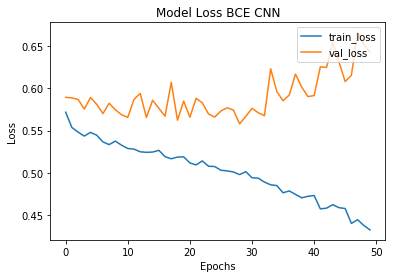

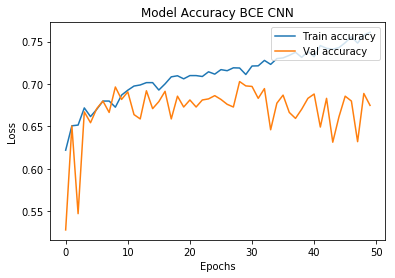

In [21]:
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.770895,0.739623,0.754935,0.678034,0.635777,0.67476
Confirmed,0.496350,0.538614,0.516619,0.678034,0.635777,0.67476


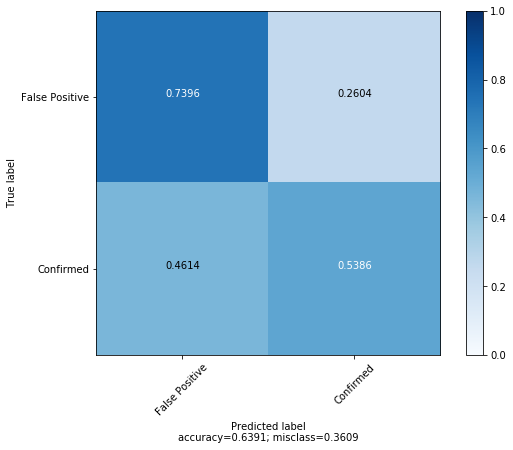

{'Precision raw': array([0.77089479, 0.49635036]), 'Recall raw': array([0.73962264, 0.53861386]), 'F1 raw': array([0.754935  , 0.51661918]), 'F1 weighted': 0.6780343706780266, 'F1 macro': 0.6357770928465841, 'F1 micro': 0.6747603833865815, 'Confusion Matrix': array([[784, 276],
       [233, 272]])}


In [22]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN'))

In [23]:
hist1=model1.fit(x_train, y_train, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist1.history['loss'],label="train_loss")
plt.plot(hist1.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist1.history['acc'],label="Train accuracy" )
plt.plot(hist1.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

NameError: name 'model1' is not defined

In [ ]:
predichos=model1.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1'))

In [ ]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [ ]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

In [ ]:
y_train_cat=to_categorical(y_train, 2)
y_train_cat[:3]
y_val_cat=to_categorical(y_val, 2)
y_val_cat[:3]

In [ ]:
hist2=model2.fit(x_train, y_train_cat, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

In [ ]:
predichos=model2.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal'))

# Segundo Modelo

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.1))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))
model4.summary()
model4.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

In [ ]:
hist3=model3.fit(x_train, y_train, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE'))

In [ ]:
hist4=model4.fit(x_train, y_train_cat, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal'))

In [ ]:
model5 = Sequential()
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(MaxPooling2D((2,2)))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(GlobalAveragePooling2D())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(2, activation='softmax'))
model5.summary()
model5.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

In [ ]:
hist5=model5.fit(x_train, y_train, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist5.history['loss'],label="train_loss")
plt.plot(hist5.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
plt.plot(hist5.history['acc'],label="Train accuracy" )
plt.plot(hist5.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
predichos=model5.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 5 BCE'))

In [ ]:
model6 = Sequential()
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling2D())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))
model6.add(Dense(2, activation='softmax'))
model6.summary()
model6.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])


In [ ]:
hist6=model6.fit(x_train, y_train_cat, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist6.history['loss'],label="train_loss")
plt.plot(hist6.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist6.history['acc'],label="Train accuracy" )
plt.plot(hist6.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model6.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 6 Focal'))

In [ ]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(GlobalAveragePooling2D())
#model7.add(Dropout(0.15))
model7.add(Dense(1, activation='sigmoid'))
model7.summary()

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))

In [ ]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(GlobalAveragePooling2D())
model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.15))
model8.add(Dense(2, activation='softmax'))
model8.summary()

model8.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

hist8=model8.fit(x_train, y_train_cat, batch_size=128, epochs=150, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist8.history['loss'],label="train_loss")
plt.plot(hist8.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist8.history['acc'],label="Train accuracy" )
plt.plot(hist8.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model8.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 150 epochs CNN 8 Focal'))

In [ ]:
x_train.shape

In [ ]:
model9 = Sequential()
model9.add(Conv1D(32, 3, input_shape=(15,15), strides=1,activation="relu", padding="same"))
model9.add(Conv1D(32, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model9.add(Dropout(0.25))

model9.add(GlobalAveragePooling1D())
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(1, activation='sigmoid'))
model9.summary()

model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist9=model9.fit(np.squeeze(x_train), y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(np.squeeze(x_val),y_val))
plt.plot(hist9.history['loss'],label="train_loss")
plt.plot(hist9.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist9.history['acc'],label="Train accuracy" )
plt.plot(hist9.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model9.predict_classes(np.squeeze(x_val))
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))